In [1]:
### IMPORTS
import openmc
import numpy as np
from Meshing.Meshing import *
from Fields.Fields import *
from Kernels.Kernels import *
from Solvers.Solvers import *
from Subchannel.FluidRelation import FluidRelation
from Subchannel.Channel import Channel
from Subchannel.Channel import ChannelInterface
from Aux.CSVObjects import *
from Aux.ReactorPhysicsObjects import *

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.patches import Rectangle

import pandas as pd

from Data.msre_data import msre_data_dict

class openmc_channel():
  def __init__(self, ch_id: int):
    self.ch_type = None
    self.power = None
    self.ch_id = ch_id
    self.x = None
    self.y = None
  def set_xy(self, x: float, y: float):
    self.x = x
    self.y = y

NOW RUNNING MSRE DATA USER INPUT
EXTENRAL TAU IS 7.017500000000002
Channel length L1 is 1.8148679046133467


LP AREA IS 0.27318354685967605
UP AREA IS 0.2803725875665097
DOWNCOMER AREA IS 0.09345752918883656
EXTERNAL LOOP AREA IS 0.5044909316020467


In [2]:
### INTEGRATED FSRC ###
"""
Openmc tallies are integral(sigmaF*phi)dV
So we need to normalize tally data by volume eventually.
"""

### FLUID DATA ###
fluid = msre_data_dict['fluid']

### BC DATA ###
mdot_csv = load_csv('Data/msre_flow_coastdown.csv')
MDOT_MAX = msre_data_dict['mdot_max']
START_TIME = -100
mdot_bc = MDOT_MAX / 100 * csv_interpolator(csv_df=mdot_csv, x_value=START_TIME, x_label='time', y_label='mdot')

### CHANNEL DATA ###
full_area = msre_data_dict['full_ch_area']
half_area = msre_data_dict['half_ch_area']
full_dh = msre_data_dict['full_ch_dh']
half_dh = msre_data_dict['half_ch_dh']

temp_tolerance = msre_data_dict['temp_tol']
max_temp_iterations = msre_data_dict['max_temp_iterations']
nZones = 50

L0 = msre_data_dict['L0']
L1 = msre_data_dict['L1']

gravity = msre_data_dict['gravity']
pressure_bc = msre_data_dict['pressure_bc']
T_bc = msre_data_dict['temp_bc']

fric = 'type1'
heat_source = [0.0]*nZones

### VOLUMES (cm3) ### (volumes from openmc we use to et F''' correctly from openmc tallies )
downcomer_vol = (np.pi * 74.299**2)*L1*100 - (np.pi * 71.737**2) * L1*100
bypass_vol = (np.pi * 71.097**2)*L1*100 - (np.pi * 70.285**2) * L1*100
up_vol = 187386.72708629695 # obtained from running volume caclulation in msreCore_r5_fission_density.py
lp_vol = 425455.22629216046 # obtained from running volume caclulation in msreCore_r5_fission_density.py
mesh_vol = (0.50885*2.0) * (L1*100/nZones) * (5.08339 - 2.0*0.50885)

### PLENUM, BYPASS, EXTERNAL LOOP & DOWNCOMER INFORMATION ###
#   (put channel geometry information in terms of m3 or m)
bypass_dh = msre_data_dict['bypass_dh']
bypass_area = bypass_vol/100.0/100.0/100.0 / (L1) # area ion m2
bypass_fric = 'annulus'
bypass_channel_rout = 71.097/100.0
bypass_channel_rin = 70.285/100.0
bypass_inlet_loss = 138 * 1.0

downcomer_dh = 1.0
downcomer_area = msre_data_dict['dc_area']
downcomer_fric = 'none'

up_dh = 1.0 # dummy variable
up_area = msre_data_dict['up_area'] # length of 1.0 - 2 second residence time
up_fric = 'none'

lp_dh = 1.0  # dummy variable
lp_area = msre_data_dict['lp_area']
lp_fric = 'none'

ex_dh = 1.0
ex_area = msre_data_dict['ex_area']
ex_fric = 'none'

ch_special_form_loss = 12.54745 # form loss coeffs. in  center of the core.

### TRACER DATA ###
tracer_names = msre_data_dict['tracer_names']
initial_value_tracers = msre_data_dict['initial_value_tracers']
scheme_tracers = msre_data_dict['tracer_scheme']
# dnp data from openmc
decay_consts = msre_data_dict['decay_consts']
beta = msre_data_dict['beta']
# singh et al nonlinear dynamic model of the msre
# decay_consts = [0.0124, 0.0305, 0.111, 0.301, 1.14, 3.01]
# beta = [2.23e-4, 14.57e-4, 13.07e-4, 26.28e-4, 7.66e-4, 2.80e-4]

# other tracer stuff
boundary = 'lower' # must be lower anyways
phi_tracer = msre_data_dict['phi_tracer']
rho_tracer = msre_data_dict['rho_tracer']


##### PRINT SOME GEOMETRY INFORMATION #####
print("bypass area m2", bypass_area)
print("bypass vol cm3", bypass_vol)
print("downcomer area m2", downcomer_area)
print("bypass vol cm3", downcomer_vol)

bypass area m2 0.036066169787045986
bypass vol cm3 65455.33398884535
downcomer area m2 0.09345752918883656
bypass vol cm3 213321.16526250355


In [3]:
# GET TALLY
# RUN FROM INL - PROJECTS/MOTHMAN/OPENMC_FISSION_DENSITY
sp = openmc.StatePoint('OpenMC/statepoint.450.h5')

# UP TALLY
up_tally = sp.tallies[100002].mean.reshape(1) / up_vol

# LP TALLY
lp_tally = sp.tallies[100003].mean.reshape(1) / lp_vol

# BYPASS TALLY
bypass_tally = sp.tallies[100004].mean.reshape(1) / bypass_vol

# DOWNCOMER TALLY
downcomer_tally = sp.tallies[100001].mean.reshape(1) / downcomer_vol

# TALLY DATA
print('downcomer_tally =', downcomer_tally)
print('lp_tally =', lp_tally)
print('up_tally =', up_tally)
print('bypass_tally =', bypass_tally)


# GRID TALLY
grid_tally = sp.tallies[100000]
# Get F (x*y*z, EnergyBins, 1, 1)
F = grid_tally.get_values().reshape(50,55,55)
M = grid_tally.filters[0]
xgrid = M.mesh.x_grid
ygrid = M.mesh.y_grid
zgrid = M.mesh.z_grid

# PRINT OUT INTEGRATED DATA
total_F = downcomer_tally*downcomer_vol + bypass_tally*bypass_vol + lp_tally*lp_vol + up_tally*up_vol + np.sum(F)
print('============================================')
print("total F downcomer =", downcomer_tally*downcomer_vol)
print("total F bypass =", bypass_tally*bypass_vol)
print("total F LP =", lp_tally*lp_vol)
print("total F UP =", up_tally*up_vol)
print("total F channels =", np.sum(F))
print("total F ALL =", total_F)
print('============================================')
print("fraction F downcomer =", downcomer_tally*downcomer_vol / total_F)
print("fraction F bypass =", bypass_tally*bypass_vol / total_F)
print("fraction F LP =", lp_tally*lp_vol / total_F)
print("fraction F UP =", up_tally*up_vol / total_F)
print("fraction F channels =", np.sum(F) / total_F)
print('============================================')
# NOW MAKE VALUES OF FISSION DENSITY BY DIVIDING BY VOLUME IF NOT ALREADY DONE ABOVE
# normalize so that int(F)dV == 1
downcomer_F = (downcomer_tally / total_F)[0] # already normalized above
bypass_F = (bypass_tally / total_F)[0]
lp_F = (lp_tally / total_F)[0]
up_F = (up_tally / total_F)[0]
F = F / mesh_vol / total_F # normalize to volume of each mesh voxel.
print('============================================')
print("Integrated F by vol = ", downcomer_F*downcomer_vol + bypass_F*bypass_vol + up_F * up_vol + lp_F * lp_vol + np.sum(F*mesh_vol))
print('============================================')

# integrate all to double check:




### From top to bottom - lists the number of HORIZONTAL --- channels in each row
nchannels = [3,11,15,17,19,21,23,23,25,25,25,27,27,27]
nchannels += nchannels[-1::-1]

### from top to bottom list out the yCoords
yCoords_hor = np.linspace(13.5*5.08339, -13.5*5.08339, 28) # top to bottom yCoords
xCoords_hor = np.linspace(-13*5.08339, 13*5.08339, 27) # left to right xCoords

print(nchannels)
print(sum(nchannels)*2)
len(nchannels)

### AREA RATIOS FOR CHANNELS THAT ARE HORIZONTALLY OPPOSED (FROM TOP TO BOTTOM)
channel_area_ratio_horizontal =     np.array([[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0],
                                              [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0],
                                              [0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0],
                                              [0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0],
                                              [0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0],
                                              [0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0],
                                              [0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0],
                                              [0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0],
                                              [0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0],
                                              [0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0],
                                              [0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0],
                                              [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1],
                                              [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1],
                                              [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1],
                                              [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1],
                                              [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1],
                                              [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1],
                                              [0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0],
                                              [0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0],
                                              [0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0],
                                              [0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0],
                                              [0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0],
                                              [0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0],
                                              [0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0],
                                              [0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0],
                                              [0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0],
                                              [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0],
                                              [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0]])
channel_area_ratio_vertical = np.transpose(channel_area_ratio_horizontal)



openmc_channel_list = []
ch_arr_list = []


### NOW GET POWER DISTRIBUTION IN EACH CHANNEL ###
power_dict = {} # Keys are channel indexes - values will be the axial power distribution.
for z in range(50):
  F_test = F[z,:,:]
  hor_arr = np.array([])
  ### HORIZONTALLY ORIENTED CHANNELS ###
  for ridx, row in enumerate(F_test[0::2, :]):
    this_nchannel = nchannels[ridx]
    middle = 27
    rightmost = 27 + (this_nchannel-1)
    leftmost = 27 - (this_nchannel-1)
    channel_vals = row[int(leftmost):int(rightmost+1):2]
    nzeros = int((27 - this_nchannel)/2)
    zeros = np.zeros(nzeros)

    channel_vals = np.append(zeros,channel_vals)
    channel_vals = np.append(channel_vals, zeros)
    print("ROW",ridx)
    print(channel_vals)
    try:
      hor_arr = np.vstack([hor_arr, channel_vals])
    except:
      hor_arr = channel_vals

  ### VERTICALLY ORIENTED CHANNELS ###
  ver_arr = np.array([])
  for cidx, col in enumerate(np.transpose(F_test)[0::2, :]):
    this_nchannel = nchannels[cidx]
    middle = 27
    rightmost = 27 + (this_nchannel-1)
    leftmost = 27 - (this_nchannel-1)
    channel_vals = col[int(leftmost):int(rightmost+1):2]
    nzeros = int((27 - this_nchannel)/2)
    zeros = np.zeros(nzeros)

    channel_vals = np.append(zeros,channel_vals)
    channel_vals = np.append(channel_vals, zeros)
    print("COL",cidx)
    print(channel_vals)
    try:
      ver_arr = np.vstack([ver_arr, channel_vals])
    except:
      ver_arr = channel_vals

  # transpose after we are done making ver_arr (since we transposed F_test while iterating.)
  ver_arr = np.transpose(ver_arr) # np.shape(ver_arr) = (27, 28) ||| hor_arr shape is 28, 27

  # Now go through and make openmc_channel objects with power appended to them.
  # also attach to openmc_channel object the channel coordinatres
  ch_idx = int(0)
  openmc_channel_list = []
  for ridx, row in enumerate(hor_arr):
    for cidx, col in enumerate(row):
      if col > 1e-15:
        this_p = col
        try:
          power_dict[ch_idx] = np.append(power_dict[ch_idx], this_p)
        except:
          power_dict[ch_idx] = np.array([this_p])
        this_ch = openmc_channel(ch_id=ch_idx)
        this_ch.ch_type = channel_area_ratio_horizontal[ridx, cidx]
        this_ch.set_xy(x=xCoords_hor[cidx], y=yCoords_hor[ridx])
        openmc_channel_list.append(this_ch)
        ch_idx += 1
  for ridx, row in enumerate(ver_arr):
    for cidx, col in enumerate(row):
      if col > 1e-15:
        this_p = col
        try:
          power_dict[ch_idx] = np.append(power_dict[ch_idx], this_p)
        except:
          power_dict[ch_idx] = np.array([this_p])
        this_ch = openmc_channel(ch_id=ch_idx)
        this_ch.ch_type = channel_area_ratio_vertical[ridx,cidx]
        this_ch.set_xy(x=yCoords_hor[cidx], y=xCoords_hor[ridx]) # flip xy since transposed compared to hor_arr
        openmc_channel_list.append(this_ch)
        ch_idx += 1

# we now have power dict with powers for each channel. channels 1-~500 are horizontally opposed channels and ~500-1152
# are vertically oriented channels.

# Now assign power shape to each of the channels
for this in openmc_channel_list:
  ch_id = this.ch_id
  this.power= power_dict[ch_id]

# Now make a channel object for this channel:
for this in openmc_channel_list:
  this_fsrc = this.power
  if this.ch_type == 0.5:
    area = half_area
    Dh = half_dh
  elif this.ch_type == 1.0:
    area = full_area
    Dh = full_dh
  else:
    raise Exception("This channel type unknown!")
  this_channel = Channel(gravity=gravity,
              Dh=Dh,
              area=area,
              temp_tolerance=temp_tolerance,
              max_temp_iterations=max_temp_iterations,
              nZones=nZones,
              L0=L0,
              L1=L1,
              fluid=fluid,
              pressure_bc=pressure_bc,
              T_bc=T_bc,
              mdot_bc=1.0,
              fric=fric,
              heat_source=heat_source)
  # set x and y coords
  this_channel.set_xy(x=this.x, y=this.y)

  # set form loss coords
  _this_r = (this.x ** 2 + this.y ** 2)**0.5 / 100
  inlet_form_loss_value = 38.1 * _this_r + 47.10
  this_channel.set_form_loss_coeffs(inlet=inlet_form_loss_value, outlet=0.5)

  # adding tracers to each channel
  for tidx, name in enumerate(tracer_names):
    this_channel.add_tracer_to_channel(name=name,
                                       initial_value=0.0,
                                       scheme=scheme_tracers,
                                       decay_const=decay_consts[tidx],
                                       boundary=boundary,
                                       phi=phi_tracer,
                                       rho=rho_tracer,
                                       source=this.power,
                                       beta=beta[tidx])
  # append channel to channel array.
  ch_arr_list.append(this_channel)


### MAKE BYPASS CHANNEL ###
bypass_channel = Channel(gravity=gravity,
              Dh=bypass_dh,
              area=bypass_area,
              temp_tolerance=temp_tolerance,
              max_temp_iterations=max_temp_iterations,
              nZones=nZones,
              L0=L0,
              L1=L1,
              fluid=fluid,
              pressure_bc=pressure_bc,
              T_bc=T_bc,
              mdot_bc=1.0,
              fric=bypass_fric,
              heat_source=heat_source)
bypass_channel.set_annulus_parameters(Rout=bypass_channel_rout, Rin=bypass_channel_rin)
bypass_channel.set_form_loss_coeffs(inlet=bypass_inlet_loss, outlet=0.5)

### MAKE DOWNCOMER CHANNEL ###
downcomer_channel = Channel(gravity=gravity,
              Dh=downcomer_dh,
              area=downcomer_area,
              temp_tolerance=temp_tolerance,
              max_temp_iterations=max_temp_iterations,
              nZones=nZones,
              L0=0,
              L1=1.0,
              fluid=fluid,
              pressure_bc=0.0,
              T_bc=0.0,
              mdot_bc=0.0,
              fric=downcomer_fric,
              heat_source=heat_source)

### MAKE UPPER PLENUM CHANNEL ###
upper_plenum_channel = Channel(gravity=gravity,
              Dh=up_dh,
              area=up_area,
              temp_tolerance=temp_tolerance,
              max_temp_iterations=max_temp_iterations,
              nZones=nZones,
              L0=0,
              L1=1.0,
              fluid=fluid,
              pressure_bc=0.0,
              T_bc=1.0,
              mdot_bc=1.0,
              fric=up_fric,
              heat_source=heat_source)

### MAKE LOWER PLENUM CHANNEL ###
lower_plenum_channel = Channel(gravity=gravity,
              Dh=lp_dh,
              area=lp_area,
              temp_tolerance=temp_tolerance,
              max_temp_iterations=max_temp_iterations,
              nZones=nZones,
              L0=0,
              L1=1.0,
              fluid=fluid,
              pressure_bc=0.0,
              T_bc=1.0,
              mdot_bc=1.0,
              fric=lp_fric,
              heat_source=heat_source)

### MAKE EXTERNAL LOOP CHANNEL
ex_channel = Channel(gravity=gravity,
              Dh=ex_dh,
              area=ex_area,
              temp_tolerance=temp_tolerance,
              max_temp_iterations=max_temp_iterations,
              nZones=nZones,
              L0=0,
              L1=1.0,
              fluid=fluid,
              pressure_bc=0.0,
              T_bc=1.0,
              mdot_bc=1.0,
              fric=ex_fric,
              heat_source=heat_source)

### ADD TRACERS TO EXTRA CHANNELS ###
for tidx, name in enumerate(tracer_names):
  bypass_channel.add_tracer_to_channel(name=name,
                                       initial_value=0.0,
                                       scheme=scheme_tracers,
                                       decay_const=decay_consts[tidx],
                                       boundary=boundary,
                                       phi=phi_tracer,
                                       rho=rho_tracer,
                                       source=np.ones(nZones)*bypass_tally,
                                       beta=beta[tidx])
  downcomer_channel.add_tracer_to_channel(name=name,
                                      initial_value=0.0,
                                      scheme=scheme_tracers,
                                      decay_const=decay_consts[tidx],
                                      boundary=boundary,
                                      phi=phi_tracer,
                                      rho=rho_tracer,
                                      source=downcomer_F,
                                      beta=beta[tidx])
  upper_plenum_channel.add_tracer_to_channel(name=name,
                                       initial_value=0.0,
                                       scheme=scheme_tracers,
                                       decay_const=decay_consts[tidx],
                                       boundary=boundary,
                                       phi=phi_tracer,
                                       rho=rho_tracer,
                                       source=up_F,
                                       beta=beta[tidx])
  lower_plenum_channel.add_tracer_to_channel(name=name,
                                       initial_value=0.0,
                                       scheme=scheme_tracers,
                                       decay_const=decay_consts[tidx],
                                       boundary=boundary,
                                       phi=phi_tracer,
                                       rho=rho_tracer,
                                       source=lp_F,
                                       beta=beta[tidx])
  ex_channel.add_tracer_to_channel(name=name,
                                       initial_value=0.0,
                                       scheme=scheme_tracers,
                                       decay_const=decay_consts[tidx],
                                       boundary=boundary,
                                       phi=phi_tracer,
                                       rho=rho_tracer,
                                       source=0.0,
                                       beta=beta[tidx])

### MAKE CHANNEL ARRAY ###
ch = ChannelArray(channels=ch_arr_list+[bypass_channel],
                  coupling_method='pressure_method',
                  flow_ratios=[],
                  fluid=fluid,
                  mdot_relaxation=1.0,
                  epsilon=1e-6)
ch.mdot_bc = mdot_bc

### MAKE CHANNELS THAT HAVE SPECIAL FORM LOSS IN MIDDLE OF CORE ###
special_channels = [892, 891, 865, 864, 863, 862, 836, 835, 247, 273, 274, 275, 300, 301, 302, 328]
for idx, chan in enumerate(ch.channels):
  if idx in special_channels:
    chan.set_form_loss_coeffs(inlet=ch_special_form_loss, outlet=0.5)



downcomer_tally = [6.71734031e-08]
lp_tally = [3.45716945e-08]
up_tally = [8.40225952e-08]
bypass_tally = [1.28862455e-07]
total F downcomer = [0.01432951]
total F bypass = [0.00843474]
total F LP = [0.01470871]
total F UP = [0.01574472]
total F channels = 0.3872369143530796
total F ALL = [0.44045459]
fraction F downcomer = [0.03253345]
fraction F bypass = [0.01915007]
fraction F LP = [0.03339438]
fraction F UP = [0.03574652]
fraction F channels = [0.87917558]
Integrated F by vol =  1.0
[3, 11, 15, 17, 19, 21, 23, 23, 25, 25, 25, 27, 27, 27, 27, 27, 27, 25, 25, 25, 23, 23, 21, 19, 17, 15, 11, 3]
1152
ROW 0
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.19989139e-08 4.27701331e-08 4.11244239e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00

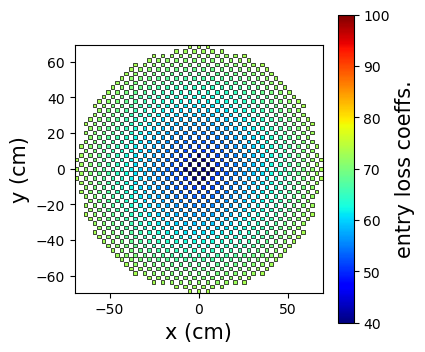

In [4]:
ch.plot_map(var='entry_loss', zNode=0, figsize=(4,4), radius=1, cmap_label='entry loss coeffs.',
            cmap_fontsize=15, cmap_name='jet', cmap_minmax=(40,100),
            y_label='y (cm)', x_label='x (cm)')

In [5]:
### MAKE CHANNEL INTERFACES
ch_to_up = ChannelInterface(ch1=ch, ch2=upper_plenum_channel)
up_to_ex = ChannelInterface(ch1=upper_plenum_channel, ch2=ex_channel)
ex_to_downcomer = ChannelInterface(ch1=ex_channel, ch2=downcomer_channel)
downcomer_to_lp = ChannelInterface(ch1=downcomer_channel, ch2=lower_plenum_channel)
lp_to_ch = ChannelInterface(ch1=lower_plenum_channel, ch2=ch)

### SOLVE THERMAL HYDRAULICS ST.ST. ###
ch.solve_channel_TH(_dt=1e321)
ch_to_up.update_interface_conditions(tracer_bool=False, th_bool=True)

upper_plenum_channel.solve_channel_TH(_dt=1e321)
up_to_ex.update_interface_conditions(tracer_bool=False, th_bool=True)

ex_channel.solve_channel_TH(_dt=1e321)
ex_to_downcomer.update_interface_conditions(tracer_bool=False, th_bool=True)

downcomer_channel.solve_channel_TH(_dt=1e321)
downcomer_to_lp.update_interface_conditions(tracer_bool=False, th_bool=True)

lower_plenum_channel.solve_channel_TH(_dt=1e321)
lp_to_ch.update_interface_conditions(tracer_bool=False, th_bool=True)

### PRINT CHANNEL RESIDENCE TIMES
print(ch.get_channel_residence_time())
print(upper_plenum_channel.get_channel_residence_time())
print(ex_channel.get_channel_residence_time())
print(downcomer_channel.get_channel_residence_time())
print(lower_plenum_channel.get_channel_residence_time())
print("total residence time =", ch.get_channel_residence_time()
      + upper_plenum_channel.get_channel_residence_time()
      + ex_channel.get_channel_residence_time()
      + downcomer_channel.get_channel_residence_time()
      + lower_plenum_channel.get_channel_residence_time())

### CONVERGE TRACERS BSAED ON VALUE OF C1 BETWEEN ITERATIONS - ST.ST. TRACER SOLUTION ###
ch_outlet_value = 1.0
iter_num = 0
tracer_to_converge_on = 'c1'
while True:
  iter_num += 1
  ch.solve_all_tracers(_dt=1e321)
  ch_to_up.update_interface_conditions(tracer_bool=True, th_bool=False)

  upper_plenum_channel.solve_all_tracers(_dt=1e321)
  up_to_ex.update_interface_conditions(tracer_bool=True, th_bool=False)

  ex_channel.solve_all_tracers(_dt=1e321)
  ex_to_downcomer.update_interface_conditions(tracer_bool=True, th_bool=False)

  downcomer_channel.solve_all_tracers(_dt=1e321)
  downcomer_to_lp.update_interface_conditions(tracer_bool=True, th_bool=False)

  lower_plenum_channel.solve_all_tracers(_dt=1e321)
  lp_to_ch.update_interface_conditions(tracer_bool=True, th_bool=False)

  _,_,_,_,tracer_outlet_weighted_value = ch.get_outlet_conditions()
  diff = np.abs(ch_outlet_value - tracer_outlet_weighted_value[tracer_to_converge_on])

  ch_outlet_value = tracer_outlet_weighted_value[tracer_to_converge_on]
  print("Iteration nuimber", iter_num, " and diff is", diff)
  if diff < 1e-12:
    break



Now converging channel arrays ...
Iterating ChannelArray mass flows for first time, total area is 0.3633403605618319
	Iteration number 1 ... Rel. Diff. Before iterating = 1.0
	Iteration number 2 ... Rel. Diff. Before iterating = 0.07114767817622247
	Iteration number 3 ... Rel. Diff. Before iterating = 1.3859366192208635
	Iteration number 4 ... Rel. Diff. Before iterating = 0.20289589978549605
	Iteration number 5 ... Rel. Diff. Before iterating = 0.048134985637825256
	Iteration number 6 ... Rel. Diff. Before iterating = 0.003940493451591642
	Iteration number 7 ... Rel. Diff. Before iterating = 8.717840748906358e-05
	Iteration number 8 ... Rel. Diff. Before iterating = 2.1744145617397237e-07
	Solved channel coupling
8.999066521321053
3.9000000000000066
7.017500000000015
1.3000000000000007
3.800000000000001
total residence time = 25.016566521321078
Iteration nuimber 1  and diff is 0.1148853992370058
Iteration nuimber 2  and diff is 0.25231816103770954
Iteration nuimber 3  and diff is 0.18

In [6]:
print("bypass ratio =", bypass_channel.mdot_bc / mdot_bc)

bypass ratio = 0.06930930148297317


### SAVE TO CSV SOME IMPORTANT STUFF

In [7]:
# power by channel to csv.
ch.channelwise_data_to_csv(filename='power_by_channel.csv', data_type='fsrc', tracer_name='c1')

In [8]:
### Make different sets of channels based on distance from the core ###
set_1_channels = special_channels
set_2_channels = []
set_3_channels = []
set_4_channels = []
set_5_channels = []
set_6_channels = []
set_7_channels = []
set_8_channels = []

# fission source vectors
set_1_F = np.zeros(nZones)
set_2_F = np.zeros(nZones)
set_3_F = np.zeros(nZones)
set_4_F = np.zeros(nZones)
set_5_F = np.zeros(nZones)
set_6_F = np.zeros(nZones)
set_7_F = np.zeros(nZones)
set_8_F = np.zeros(nZones)

# mdot vectors (from fully converged st.st. soln)
set_1_total_mass_flow = 0.0
set_2_total_mass_flow = 0.0
set_3_total_mass_flow = 0.0
set_4_total_mass_flow = 0.0
set_5_total_mass_flow = 0.0
set_6_total_mass_flow = 0.0
set_7_total_mass_flow = 0.0
set_8_total_mass_flow = 0.0

# mdot vectors (from fully converged st.st. soln)
set_1_tau = 0.0
set_2_tau = 0.0
set_3_tau = 0.0
set_4_tau = 0.0
set_5_tau = 0.0
set_6_tau = 0.0
set_7_tau = 0.0
set_8_tau = 0.0

max_rad = 0
for idx, chan in enumerate(ch.channels):

  # Ignore special channels for control rodded regions in the core.

  if (idx not in set_1_channels) & (chan.xCoord is not None):
    chan_rad = (chan.xCoord**2 + chan.yCoord**2)**0.5
    if (chan_rad > 0.0) & (chan_rad <= 14.0):
      set_2_channels.append(idx)
      set_2_F += chan.tracer_kernels['c1'][2].Q * chan.vol_vec
      set_2_total_mass_flow += chan.mdot_bc
      set_2_tau += chan.get_channel_residence_time()

    elif (chan_rad > 11.66) & (chan_rad <= 23.33):
      set_3_channels.append(idx)
      set_3_F += chan.tracer_kernels['c1'][2].Q * chan.vol_vec
      set_3_total_mass_flow += chan.mdot_bc
      set_3_tau += chan.get_channel_residence_time()

    elif (chan_rad > 23.33) & (chan_rad <= 35.0):
      set_4_channels.append(idx)
      set_4_F += chan.tracer_kernels['c1'][2].Q * chan.vol_vec
      set_4_total_mass_flow += chan.mdot_bc
      set_4_tau += chan.get_channel_residence_time()

    elif (chan_rad > 35.0) & (chan_rad <= 46.66):
      set_5_channels.append(idx)
      set_5_F += chan.tracer_kernels['c1'][2].Q * chan.vol_vec
      set_5_total_mass_flow += chan.mdot_bc
      set_5_tau += chan.get_channel_residence_time()

    elif (chan_rad > 46.66) & (chan_rad <= 58.33):
      set_6_channels.append(idx)
      set_6_F += chan.tracer_kernels['c1'][2].Q * chan.vol_vec
      set_6_total_mass_flow += chan.mdot_bc
      set_6_tau += chan.get_channel_residence_time()

    elif (chan_rad > 58.33) & (chan_rad <= 70.0):
      set_7_channels.append(idx)
      set_7_F += chan.tracer_kernels['c1'][2].Q * chan.vol_vec
      set_7_total_mass_flow += chan.mdot_bc
      set_7_tau += chan.get_channel_residence_time()


  if chan.xCoord is None: # bypass channel
    set_8_channels.append(idx)
    set_8_F += chan.tracer_kernels['c1'][2].Q * chan.vol_vec
    set_8_total_mass_flow += chan.mdot_bc
    set_8_tau += chan.get_channel_residence_time()


  if idx in set_1_channels:
    # central channels
    set_1_F += chan.tracer_kernels['c1'][2].Q * chan.vol_vec
    set_1_total_mass_flow += chan.mdot_bc
    set_1_tau += chan.get_channel_residence_time()

# Now average out mass flows
set_1_total_mass_flow = set_1_total_mass_flow / len(set_1_channels)
set_2_total_mass_flow = set_2_total_mass_flow / len(set_2_channels)
set_3_total_mass_flow = set_3_total_mass_flow / len(set_3_channels)
set_4_total_mass_flow = set_4_total_mass_flow / len(set_4_channels)
set_5_total_mass_flow = set_5_total_mass_flow / len(set_5_channels)
set_6_total_mass_flow = set_6_total_mass_flow / len(set_6_channels)
set_7_total_mass_flow = set_7_total_mass_flow / len(set_7_channels)
set_8_total_mass_flow = set_8_total_mass_flow / len(set_8_channels)

# Now do residence times.
set_1_tau = set_1_tau / len(set_1_channels)
set_2_tau = set_2_tau / len(set_2_channels)
set_3_tau = set_3_tau / len(set_3_channels)
set_4_tau = set_4_tau / len(set_4_channels)
set_5_tau = set_5_tau / len(set_5_channels)
set_6_tau = set_6_tau / len(set_6_channels)
set_7_tau = set_7_tau / len(set_7_channels)
set_8_tau = set_8_tau / len(set_8_channels)

# make some dictionaries.
set_1_dict = {'mdot': set_1_total_mass_flow, 'F': set_1_F, 'nchannels': len(set_1_channels), 'tau': set_1_tau}
set_2_dict = {'mdot': set_2_total_mass_flow, 'F': set_2_F, 'nchannels': len(set_2_channels), 'tau': set_2_tau}
set_3_dict = {'mdot': set_3_total_mass_flow, 'F': set_3_F, 'nchannels': len(set_3_channels), 'tau': set_3_tau}
set_4_dict = {'mdot': set_4_total_mass_flow, 'F': set_4_F, 'nchannels': len(set_4_channels), 'tau': set_4_tau}
set_5_dict = {'mdot': set_5_total_mass_flow, 'F': set_5_F, 'nchannels': len(set_5_channels), 'tau': set_5_tau}
set_6_dict = {'mdot': set_6_total_mass_flow, 'F': set_6_F, 'nchannels': len(set_6_channels), 'tau': set_6_tau}
set_7_dict = {'mdot': set_7_total_mass_flow, 'F': set_7_F, 'nchannels': len(set_7_channels), 'tau': set_7_tau}
set_8_dict = {'mdot': set_8_total_mass_flow, 'F': set_8_F, 'nchannels': len(set_8_channels), 'tau': set_8_tau}

pd.DataFrame.from_dict(set_1_dict).to_csv('Data/model_8_channels/set_1.csv', index=False)
pd.DataFrame.from_dict(set_2_dict).to_csv('Data/model_8_channels/set_2.csv', index=False)
pd.DataFrame.from_dict(set_3_dict).to_csv('Data/model_8_channels/set_3.csv', index=False)
pd.DataFrame.from_dict(set_4_dict).to_csv('Data/model_8_channels/set_4.csv', index=False)
pd.DataFrame.from_dict(set_5_dict).to_csv('Data/model_8_channels/set_5.csv', index=False)
pd.DataFrame.from_dict(set_6_dict).to_csv('Data/model_8_channels/set_6.csv', index=False)
pd.DataFrame.from_dict(set_7_dict).to_csv('Data/model_8_channels/set_7.csv', index=False)
pd.DataFrame.from_dict(set_8_dict).to_csv('Data/model_8_channels/set_8.csv', index=False)

print(np.sum(set_1_dict['F']))
print(np.sum(set_2_dict['F']))
print(np.sum(set_3_dict['F']))
print(np.sum(set_4_dict['F']))
print(np.sum(set_5_dict['F']))
print(np.sum(set_6_dict['F']))
print(np.sum(set_7_dict['F']))
print(np.sum(set_8_dict['F']))


1.1313273195752131e-08
2.7728540558819083e-08
5.867934278327875e-08
1.3340196610763968e-07
1.4892733158460444e-07
1.2489063235560383e-07
8.02803535841492e-08
8.43473500074225e-09


In [9]:
## we use this part to homogenize a bunch of channels and dump them out.
set_1_ch = ch.homogenize_channel(set_1_channels, do_tracers=True)
set_2_ch = ch.homogenize_channel(set_2_channels, do_tracers=True)
set_3_ch = ch.homogenize_channel(set_3_channels, do_tracers=True)
set_4_ch = ch.homogenize_channel(set_4_channels, do_tracers=True)
set_5_ch = ch.homogenize_channel(set_5_channels, do_tracers=True)
set_6_ch = ch.homogenize_channel(set_6_channels, do_tracers=True)
set_7_ch = ch.homogenize_channel(set_7_channels, do_tracers=True)
set_8_ch = ch.homogenize_channel(set_8_channels, do_tracers=True)
channels_coarse_list = [set_1_ch, set_2_ch, set_3_ch, set_4_ch, set_5_ch, set_6_ch, set_7_ch, set_8_ch]

# dump out set of 8 channels
set_1_ch.dump_channel_to_pkl(filename='Data/model_8_channels/channel_1_setup.pkl')
set_2_ch.dump_channel_to_pkl(filename='Data/model_8_channels/channel_2_setup.pkl')
set_3_ch.dump_channel_to_pkl(filename='Data/model_8_channels/channel_3_setup.pkl')
set_4_ch.dump_channel_to_pkl(filename='Data/model_8_channels/channel_4_setup.pkl')
set_5_ch.dump_channel_to_pkl(filename='Data/model_8_channels/channel_5_setup.pkl')
set_6_ch.dump_channel_to_pkl(filename='Data/model_8_channels/channel_6_setup.pkl')
set_7_ch.dump_channel_to_pkl(filename='Data/model_8_channels/channel_7_setup.pkl')
set_8_ch.dump_channel_to_pkl(filename='Data/model_8_channels/channel_8_setup.pkl')

# dump out ex components
upper_plenum_channel.dump_channel_to_pkl(filename='Data/model_8_channels/upper_plenum.pkl')
lower_plenum_channel.dump_channel_to_pkl(filename='Data/model_8_channels/lower_plenum.pkl')
ex_channel.dump_channel_to_pkl(filename='Data/model_8_channels/external_loop.pkl')
downcomer_channel.dump_channel_to_pkl(filename='Data/model_8_channels/downcomer.pkl')

# 1 channel model channel
channels_all_homogenized = ch.homogenize_channel(set_1_channels+set_2_channels+set_3_channels+set_4_channels+set_5_channels+set_6_channels+set_7_channels+set_8_channels, do_tracers=True)

channels_all_homogenized.dump_channel_to_pkl(filename='Data/model_1_channels/all_channels_homogenized.pkl')


# 2 channel model channels
channels_2_ch_model_all = ch.homogenize_channel(set_1_channels+set_2_channels+set_3_channels+set_4_channels+set_5_channels+set_6_channels+set_7_channels, do_tracers=True)
channels_2_ch_model_bypass = ch.homogenize_channel(set_8_channels, do_tracers=True)

channels_2_ch_model_all.dump_channel_to_pkl(filename='Data/model_2_channels/main_channel.pkl')
channels_2_ch_model_bypass.dump_channel_to_pkl(filename='Data/model_2_channels/bypass.pkl')

In [ ]:
print("F''' * V = FV")
for this in channels_coarse_list:
  print(np.sum(this.tracer_kernels['c1'][2].Q * this.vol_vec))
print("F''' new")
for this in channels_coarse_list:
  print(np.sum(this.tracer_kernels['c1'][2].Q * this.vol_vec) / this.ch_volume)
print("mdot")
for this in channels_coarse_list:
  print(this.mdot_bc)
print("V")
for this in channels_coarse_list:
  print(this.ch_volume)
print("sources for F")
for idx, this in enumerate(channels_coarse_list):
  print('new_ch_'+str(idx), this.integrate_tracer_source(tracer_name='c1'))
print('UP', upper_plenum_channel.integrate_tracer_source(tracer_name='c1'))
print('LP', lower_plenum_channel.integrate_tracer_source(tracer_name='c1'))
print('DC', downcomer_channel.integrate_tracer_source(tracer_name='c1'))




# RUN TRANSIENT

In [ ]:
# TIME SETTINGS
Tstart = -0.1
Tend = 101
nsteps = 2500

# TIMESTEPS
timesteps = np.linspace(Tstart, Tend, nsteps)

# Update old values in channel before starting simulation
ch.update_old_to_most_recent()
upper_plenum_channel.update_old_to_most_recent()
ex_channel.update_old_to_most_recent()
lower_plenum_channel.update_old_to_most_recent()
downcomer_channel.update_old_to_most_recent()

# Transient solver
t_prev = -1e321

# setup beff dict
beta_eff_dict_mc = {}

for t_new in timesteps:
  # DT
  this_dt = t_new - t_prev
  # PRINT TIME INFORMATION
  print("NOW SOLVING AT TIME =", t_new, "| this_dt =", this_dt)
  # CHANGE MASS FLOW RATE AT CHANNEL INLET
  THIS_X_VALUE = t_new
  mdot_bc = MDOT_MAX / 100 * csv_interpolator(csv_df=mdot_csv, x_value=THIS_X_VALUE, x_label='time', y_label='mdot')
  ch.mdot_bc = mdot_bc
  print("\tmdot_bc =", mdot_bc)

  # THERMAL HYDRAULIC INFORMATION
  ch.solve_channel_TH(_dt=this_dt)
  ch_to_up.update_interface_conditions(tracer_bool=False, th_bool=True)

  upper_plenum_channel.solve_channel_TH(_dt=this_dt)
  up_to_ex.update_interface_conditions(tracer_bool=False, th_bool=True)

  ex_channel.solve_channel_TH(_dt=this_dt)
  ex_to_downcomer.update_interface_conditions(tracer_bool=False, th_bool=True)

  downcomer_channel.solve_channel_TH(_dt=this_dt)
  downcomer_to_lp.update_interface_conditions(tracer_bool=False, th_bool=True)

  lower_plenum_channel.solve_channel_TH(_dt=this_dt)
  lp_to_ch.update_interface_conditions(tracer_bool=False, th_bool=True)

  # TRACER TRANSIENT SOLUTION
  ch.solve_all_tracers(_dt=this_dt)
  ch_to_up.update_interface_conditions(tracer_bool=True, th_bool=False)

  upper_plenum_channel.solve_all_tracers(_dt=this_dt)
  up_to_ex.update_interface_conditions(tracer_bool=True, th_bool=False)

  ex_channel.solve_all_tracers(_dt=this_dt)
  ex_to_downcomer.update_interface_conditions(tracer_bool=True, th_bool=False)

  downcomer_channel.solve_all_tracers(_dt=this_dt)
  downcomer_to_lp.update_interface_conditions(tracer_bool=True, th_bool=False)

  lower_plenum_channel.solve_all_tracers(_dt=this_dt)
  lp_to_ch.update_interface_conditions(tracer_bool=True, th_bool=False)

  channel_array_weights = ch.get_channel_tracer_sources(tracer_name='c1')
  this_beff_mc, _ = compute_beff_multichannel(channels=ch.channels+[upper_plenum_channel, lower_plenum_channel, downcomer_channel],
                                              weights=channel_array_weights+[up_F, lp_F, downcomer_F],
                                              names=tracer_names)
  beta_eff_dict_mc[t_new] = this_beff_mc

  # Save channel data:
  ch.save_data(_t=t_new)
  upper_plenum_channel.save_data(_t=t_new)
  ex_channel.save_data(_t=t_new)
  lower_plenum_channel.save_data(_t=t_new)
  downcomer_channel.save_data(_t=t_new)

  ch.update_old_to_most_recent()
  upper_plenum_channel.update_old_to_most_recent()
  ex_channel.update_old_to_most_recent()
  lower_plenum_channel.update_old_to_most_recent()
  downcomer_channel.update_old_to_most_recent()

  t_prev = t_new


In [ ]:
msre_integral_worth = 'Data/msre_integral_rod_worth.csv'
msre_data = 'Data/msre_startup_datapoints.csv'

df = pd.read_csv(msre_integral_worth)
data = pd.read_csv(msre_data)

z = df['z'].values
rho = df[' rho'].values
pos = data['pos'].values
time_data = data['time'].values

startup_values = np.interp(pos, z, rho)

startup_base_insertion = startup_values[0]

In [ ]:
### EXP VALUES ###
msre_integral_worth = 'Data/msre_integral_rod_worth.csv'
msre_data = 'Data/msre_coastdown_datapoints.csv'

df = pd.read_csv(msre_integral_worth)
data = pd.read_csv(msre_data)

z = df['z'].values
rho = df[' rho'].values
pos = data['pos'].values
ornl_time_data = data['time'].values

values = np.interp(pos, z, rho)
base_insertion = values[0]

ornl_delta_rho_data = 1000*(values - startup_base_insertion) # this is the data we calculated based on experimental values

# MAKE PLOT
plt.figure(figsize=(5,3))
plt.plot(ornl_time_data, ornl_delta_rho_data, 'ko', markerfacecolor='w', markersize=3)

# COMPUTE STARTING VALUE
beff_no_flow = (0.006478751114635639 - 0.004142410989449852)*10**5

### MY VALUES ###
x = np.array(list(beta_eff_dict_mc.keys()))
y_MC = beta_eff_dict_mc[-0.1] - np.array(list(beta_eff_dict_mc.values()))
plt.plot(x, y_MC*10**5 + beff_no_flow, 'r-')
# plt.plot(x[0::50], y[0::50]*10**5, 'ks', markerfacecolor='w')
# plt.plot(x[0::50], y[0::50]*10**5, 'k+', markerfacecolor='w')

# OTHER PLOTTING STUFF
plt.grid()
plt.xlim([0,100])
plt.ylim([0,300])

In [ ]:
beta_eff_dict_mc[-0.1]

In [ ]:
### PRINT CHANNEL RESIDENCE TIMES
print("RESIDENCE TIMES")
print(ch.get_channel_residence_time())
print(upper_plenum_channel.get_channel_residence_time())
print(ex_channel.get_channel_residence_time())
print(downcomer_channel.get_channel_residence_time())
print(lower_plenum_channel.get_channel_residence_time())
print("total residence time =", ch.get_channel_residence_time()
      + upper_plenum_channel.get_channel_residence_time()
      + ex_channel.get_channel_residence_time()
      + downcomer_channel.get_channel_residence_time()
      + lower_plenum_channel.get_channel_residence_time())
print("non-core residence time =", upper_plenum_channel.get_channel_residence_time()
      + ex_channel.get_channel_residence_time()
      + downcomer_channel.get_channel_residence_time()
      + lower_plenum_channel.get_channel_residence_time())

In [ ]:
MDOT_MAX

In [ ]:
plt.plot(np.array(list(beta_eff_dict_mc.values())))

In [ ]:
len(channel_array_weights)

In [ ]:
plt.plot(ch.channels[0].mdot.T)

In [ ]:
ch.plot_map(var='entry_loss', zNode=0, figsize=(2,2), radius=1, cmap_label='default',
            cmap_fontsize=15, cmap_name='jet',
            y_label='y (cm)', x_label='x (cm)')

In [ ]:
ch.plot_map(var='mdot', zNode=25, figsize=(6,6), radius=1, cmap_label='default',
            cmap_fontsize=15, cmap_name='jet', cmap_minmax=(0.00,0.35),
            y_label='y (cm)', x_label='x (cm)')

In [ ]:
ch.plot_map(var='T', zNode=49, figsize=(5,5), radius=1, cmap_label='temp',
            cmap_fontsize=15, cmap_name='jet',
            y_label='y (cm)', x_label='x (cm)')

In [ ]:
ch.plot_map(var='entry_loss', zNode=49, figsize=(8,8), radius=1, cmap_label='default',
            cmap_fontsize=15, cmap_name='jet', cmap_minmax=(40,75),
            y_label='y (cm)', x_label='x (cm)')

In [ ]:
ch.plot_map(var='int_fission_src', zNode=0, figsize=(2,2), radius=1, cmap_label='default',
            cmap_fontsize=15, cmap_name='jet', cmap_minmax='default',
            y_label='y (cm)', x_label='x (cm)')

In [ ]:
plt.figure(figsize=(2,2))
plt.pcolormesh(xgrid, ygrid, F[24,:,:])


In [ ]:
plt.figure(figsize=(2,2))
plt.pcolormesh(ver_arr)

In [ ]:
plt.figure(figsize=(2,2))
plt.pcolormesh(hor_arr)

In [ ]:
plt.figure(figsize=(3,2))
plt.plot(power_dict[200])
# plt.ylim([0,6.2e-6])

In [ ]:
plt.figure(figsize=(2,2))
plt.pcolormesh(M.mesh.volumes[:,:,0])

In [ ]:
### GETTING CENTRAL CHANNELS FOR SPECIAL FLOW RES VALUES
central_ch_list = []
thisL = 5.08339

xVal = [-thisL/2, thisL/2,
        -1.5*thisL, -thisL/2, thisL/2, 1.5*thisL,
        -thisL/2, thisL/2,
        0.0,
        -thisL,0,thisL,
        -thisL,0,thisL,
        0]
yVal = [thisL, thisL,
        0,0,0,0,
        -thisL, -thisL,
        1.5*thisL,
        thisL/2, thisL/2,thisL/2,
        -thisL/2, -thisL/2, -thisL/2,
        -1.5*thisL]
_del_ = 0.3
for idx2, x in enumerate(xVal):
  y = yVal[idx2]
  for idx, chan in enumerate(ch.channels):
    if chan.xCoord is not None:
      if (chan.xCoord < x+_del_) & (chan.xCoord > x-_del_) & (chan.yCoord < y+_del_) & (chan.yCoord > y-_del_):
        central_ch_list.append(idx)
print(central_ch_list)

In [ ]:
core_vol = 0.0
for chan in ch.channels:
  core_vol += np.sum(chan.vol_vec)
print(core_vol)
print(ch.channels[0].rho.T[0])
print(ch.channels[0].rho.T[0] * core_vol)

# downcomer time
print(downcomer_vol / downcomer_channel.rho.T[0] / MDOT_MAX)
print(downcomer_channel.rho.T[0])
print("downcomer time ACTUAL TIME", np.sum(downcomer_channel.vol_vec) * downcomer_channel.rho.T[0] / MDOT_MAX)


In [ ]:
bypass_channel.mdot.T[25] / MDOT_MAX